<a href="https://colab.research.google.com/github/Christopher-Mao/AI-Practicum/blob/main/Newer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
!wget https://www.epa.gov/system/files/other-files/2023-08/ucmr5-occurrence-data.zip
!unzip ucmr5-occurrence-data.zip

--2024-12-08 00:52:30--  https://www.epa.gov/system/files/other-files/2023-08/ucmr5-occurrence-data.zip
Resolving www.epa.gov (www.epa.gov)... 18.65.3.104, 18.65.3.101, 18.65.3.55, ...
Connecting to www.epa.gov (www.epa.gov)|18.65.3.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8128843 (7.8M) [application/zip]
Saving to: ‘ucmr5-occurrence-data.zip’

ucmr5-occurrence-da 100%[===================>]   7.75M  11.6MB/s    in 0.7s    

2024-12-08 00:52:32 (11.6 MB/s) - ‘ucmr5-occurrence-data.zip’ saved [8128843/8128843]

Archive:  ucmr5-occurrence-data.zip
  inflating: UCMR5_ZIPCodes.txt      
  inflating: UCMR5_DataSummary_Oct2024_508.pdf  
  inflating: InstructionsforAccessingUCMRResults_July2024_508.pdf  
  inflating: UCMR5_AddtlDataElem.txt  
  inflating: UCMR5_All.txt           


In [ ]:
def text_to_pandas(file_path, sep='\t', encoding='latin-1'):
    df = pd.read_csv(file_path, sep=sep, encoding=encoding)
    return df
UCMR5_df = text_to_pandas('UCMR5_All.txt')

## Preprocessing

In [ ]:
print(UCMR5_df.shape)
# Drop unnecessary row 'lithium'
UCMR5_filtered_df = UCMR5_df[~UCMR5_df['Contaminant'].str.contains('lithium', case=False, na=False)].copy()
print(UCMR5_filtered_df.shape)

(1133967, 24)
(1095477, 24)


In [ ]:
UCMR5_filtered_df = UCMR5_filtered_df[['Size', 'FacilityWaterType', 'CollectionDate', 'Contaminant', 'AnalyticalResultsSign', 'Region']].copy()
UCMR5_filtered_df.shape

(1095477, 6)

In [ ]:
# Convert 'CollectionDate' to datetime objects, handling potential errors
UCMR5_filtered_df['CollectionDate'] = pd.to_datetime(UCMR5_filtered_df['CollectionDate'], errors='coerce')
UCMR5_filtered_df['Year'] = UCMR5_filtered_df['CollectionDate'].dt.year
UCMR5_filtered_df['Month'] = UCMR5_filtered_df['CollectionDate'].dt.month
UCMR5_filtered_df['Day'] = UCMR5_filtered_df['CollectionDate'].dt.day
UCMR5_filtered_df['Quarter'] = UCMR5_filtered_df['CollectionDate'].dt.quarter

In [ ]:
print("Range of CollectionDate in UCMR5_filtered_df:")
print(UCMR5_filtered_df['CollectionDate'].min(), UCMR5_filtered_df['CollectionDate'].max())

Range of CollectionDate in UCMR5_filtered_df:
2023-01-03 00:00:00 2024-09-30 00:00:00


## LSTM Model

In [ ]:
# Check CUDA availability
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


1. Filter Data for Training and Prediction
Training Data: Include only rows from 2023.
Test Data (Prediction): Include only rows from 2024.

In [ ]:
# Filter training and prediction datasets
train_data = UCMR5_filtered_df[UCMR5_filtered_df["Year"] == 2023]
test_data = UCMR5_filtered_df[UCMR5_filtered_df["Year"] == 2024]

# Separate features and target variable
features = ['Size', 'FacilityWaterType', 'Month', 'Day', 'Contaminant', 'Region']
target = 'AnalyticalResultsSign'

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]

2. Preprocess the Data
One-Hot Encoding and Normalization
Ensure the test data (2024) uses the same encoding and normalization as the training data:

In [ ]:
# One-hot encode categorical features
X_train = pd.get_dummies(X_train, columns=['Size', 'FacilityWaterType', 'Month', 'Day', 'Contaminant', 'Region'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Size', 'FacilityWaterType', 'Month', 'Day', 'Contaminant', 'Region'], drop_first=True)

# Ensure both datasets have the same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Normalize or standardize features (optional)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

3. Convert Data to PyTorch Tensors

In [ ]:
# Define sequence length
seq_length = 5  # however long you want the training sequence to be

# Reshape X_train and y_train into sequences
X_train_sequences = []
y_train_sequences = []

# Convert X_train and y_train into overlapping sequences
for i in range(len(X_train) - seq_length + 1):
    # Collect seq_length timesteps for input
    X_train_sequences.append(X_train[i:i+seq_length, :])
    # Use the value after the sequence as the target
    y_train_sequences.append(y_train.values[i + seq_length - 1])

# Convert sequences to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)  # Shape: (num_samples, seq_length, num_features)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.float32)  # Shape: (num_samples,)

# Optionally repeat the process for X_test if necessary
X_test_sequences = []
for i in range(len(X_test) - seq_length + 1):
    X_test_sequences.append(X_test[i:i+seq_length, :])
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)

# Create DataLoader for training
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Optional: Check shapes for debugging
print(f"X_train_tensor shape: {X_train_tensor.shape}")  # (num_samples, seq_length, num_features)
print(f"y_train_tensor shape: {y_train_tensor.shape}")  # (num_samples,)


ValueError: too many dimensions 'str'

In [ ]:
# --- Step 3: Define the LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for regression

        # Initialize hidden and cell states as None
        self.hidden = None

    def forward(self, x):
        # If hidden states are None or the batch size changes, reinitialize them
        if self.hidden is None or self.hidden[0].size(1) != x.size(0):
            self.hidden = (
                torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device),
                torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device),
            )

        # Forward propagate through LSTM
        out, self.hidden = self.lstm(x, self.hidden)

        # Detach hidden states to prevent backprop through history
        self.hidden = (self.hidden[0].detach(), self.hidden[1].detach())

        # Fully connected layer on the last time step
        out = self.fc(out[:, -1, :])
        return out


    def reset_hidden_state(self):
        """Reset hidden and cell states (e.g., at the start of each epoch)."""
        self.hidden = None


In [ ]:
# --- Step 4: Initialize the Model, Loss Function, and Optimizer ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train_tensor.shape[2]  # Number of features. tensor is num_samples, seq_length, num_features
hidden_size = 50  # Number of hidden units
num_layers = 2  # Number of stacked LSTM layers
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()  # Loss function for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Optimizer

In [ ]:
# --- Step 5: Train the Model ---
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # Reset hidden state at the start of each epoch
    model.reset_hidden_state()

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)  # Move inputs to device
        y_batch = y_batch.to(device)  # Move targets to device

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()


    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.8f}")
    print(f"Sample predictions: {predictions[:5].detach().cpu().numpy()}")
    print(f"Sample targets: {y_batch[:5].detach().cpu().numpy()}")

Epoch [1/1], Loss: 0.0000


In [ ]:
# --- Step 6: Make Predictions for 2024 ---
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    X_test_tensor = X_test_tensor.unsqueeze(1).to(device)  # Add time dimension and move to device
    predictions = model(X_test_tensor).squeeze()

# Convert predictions to a DataFrame
test_data["PredictedValue"] = predictions.cpu().numpy()

# Save the results
test_data.to_csv("predictions_2024.csv", index=False)

# --- Optional: Evaluate the Model ---

# If ground truth values for 2024 are available
if 'AnalyticalResultValue' in test_data.columns:
    y_test = test_data['AnalyticalResultValue'].values
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Calculate RMSE
    rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()
    print(f"RMSE on 2024 data: {rmse:.4f}")

<ipython-input-28-f445696cb0a7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["PredictedValue"] = predictions.cpu().numpy()


RMSE on 2024 data: 0.0024


In [ ]:
# comment :)_

## Extra Figures

<ipython-input-31-0ea37dd8e7a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CollectionDate'] = pd.to_datetime(df['CollectionDate'])


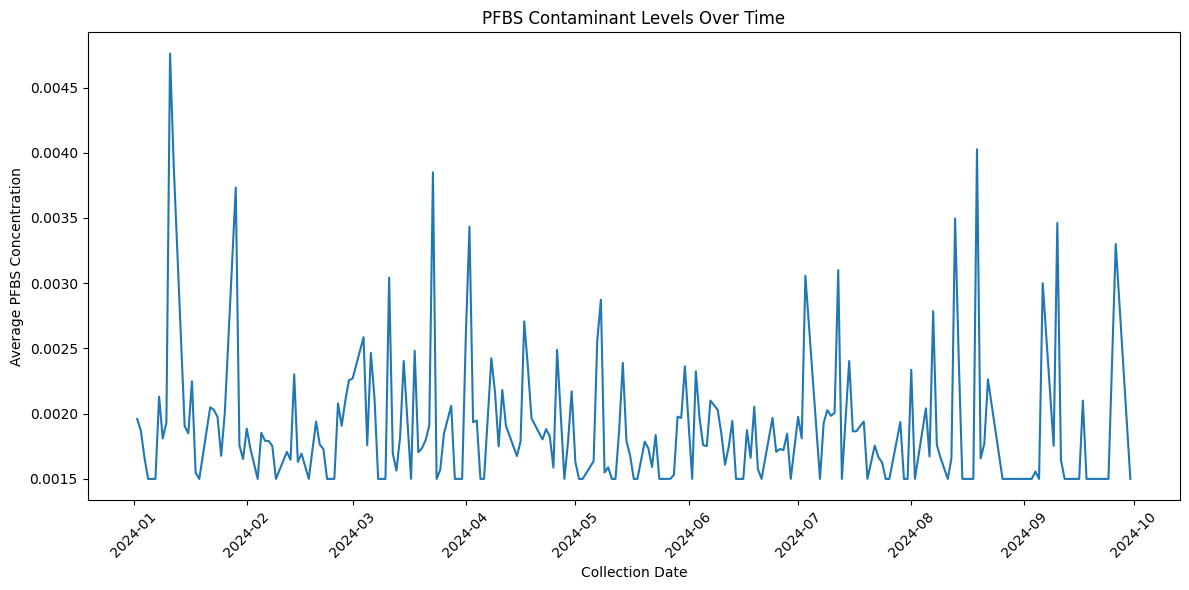

In [ ]:
# prompt: plot contaminant pfbs over time

# Assuming 'df' is the DataFrame loaded in the previous code.
df = test_data

# Convert 'CollectionDate' to datetime objects if not already done
df['CollectionDate'] = pd.to_datetime(df['CollectionDate'])

# Filter for PFBS contaminant
pfbs_data = df[df['Contaminant'] == 'PFBS']

# Group by date and calculate the mean concentration (or another aggregation)
pfbs_over_time = pfbs_data.groupby('CollectionDate')['AnalyticalResultValue'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(pfbs_over_time.index, pfbs_over_time.values)
plt.xlabel('Collection Date')
plt.ylabel('Average PFBS Concentration')
plt.title('PFBS Contaminant Levels Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()